In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython
import pyaudio
import pylab
import scipy as sp
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
pylab.rcParams['figure.figsize'] = (16, 4)

## Utilities

In [2]:
def record(sec, rate, channels=1, chunk=1024):
    ex_format = pyaudio.paInt32
    p = pyaudio.PyAudio()
    stream = p.open(format=ex_format, channels=channels, rate=rate, input=True, frames_per_buffer=chunk)
    buf = []
    for i in range(0, int(rate / chunk * sec)):
        data = stream.read(chunk)
        buf.append(np.fromstring(data, 'Int32'))
    stream.stop_stream()
    stream.close()
    p.terminate()
    ex_chan = np.array(buf).flatten()
    ex_group = np.reshape(ex_chan, [len(ex_chan) / channels, channels])
    ex = [np.average(g) for g in ex_group]
    assert len(ex) == len(ex_chan) / channels
    return ex

In [3]:
def binarize(text):
    return [int(b) for c in text for b in "{0:08b}".format(ord(c))]

In [4]:
def textarize(binary):
    bin_str = [str(b) for b in binary]
    bin_chunks = ["".join(bin_str[c:c+8]) for c in range(0, len(bin_str), 8)]
    return "".join([chr(int(c, 2)) for c in bin_chunks])

In [5]:
def raised_cosine(freq, pulse_dt, rate, beta=0.5):
    np.seterr(invalid='ignore')
    pulse_t = np.linspace(0, pulse_dt, rate * pulse_dt)
    p_const = 4 * beta / (np.pi * np.sqrt(pulse_dt))
    p_cos = np.cos((1 + beta) * np.pi * pulse_t / pulse_dt) 
    p_sinc = (1 - beta) * np.pi / (4 * beta) * np.sinc((1 - beta) * pulse_t / pulse_dt)
    p_denomin = 1 - (4 * beta * pulse_t / pulse_dt) ** 2
    p_hosp = beta / (np.pi * np.sqrt(2 * pulse_dt)) * ((np.pi + 2) * np.sin(np.pi / (4 * beta)) + (np.pi - 2) * np.cos(np.pi / (4 * beta)))
    out = p_const * (p_cos + p_sinc) / p_denomin
    out[np.isnan(out)] = p_hosp
    out *= np.cos(2 * np.pi * freq * pulse_t)
    assert not any(np.isnan(out))    
    np.seterr(invalid='warn')
    return out

In [6]:
def fast_corr(data, pattern, verify=False):
    data_len = len(data)
    data_half_len = data_len // 2
    data_even = np.zeros(data_len * 2)
    data_even[data_half_len:data_half_len + data_len] = data
    corr = sp.signal.fftconvolve(data_even, pattern[::-1], mode='valid')
    ret = corr[data_half_len:data_half_len + data_len - len(signal_delim) + 1]
    if verify:
        assert np.allclose(ret, np.correlate(data, pattern))
    return ret

## Configuration

In [97]:
origin_dt = 1
analysis_dt = 8

rate = 44100 
freq_min = 300
freq_max = 8000

pulse_dt = 0.01
pulse_df = 700
pulse_bits = 4
redundency = 5 # must be odd

## Channel analysis

In [48]:
channel = record(analysis_dt, rate)
Audio(channel, rate=rate)

In [45]:
channel_rate1, channel1 = sp.io.wavfile.read("interference.wav")
channel_rate2, channel2 = sp.io.wavfile.read("interference2.wav")
channel_rate3, channel3 = sp.io.wavfile.read("interference3.wav")
channel1 = channel1[:channel_rate1 * analysis_dt]
channel2 = channel2[:channel_rate2 * analysis_dt]
channel3 = channel3[:channel_rate3 * analysis_dt]
channel1 = sp.signal.resample(channel1, rate * analysis_dt)
channel2 = sp.signal.resample(channel2, rate * analysis_dt)
channel3 = sp.signal.resample(channel3, rate * analysis_dt)

In [98]:
channel = channel3
Audio(channel, rate=rate)

In [99]:
freq_noise = np.argsort(- np.fft.rfft(channel)) / analysis_dt
freq_noise = (freq_noise - (freq_noise % 15)).tolist()
freq_noise = sorted(set(freq_noise),key=freq_noise.index)[:2] 
print(freq_noise)

[1335.0, 675.0]


In [100]:
pulses_freq = np.arange(freq_min, freq_max, pulse_df)
for fn in freq_noise:
    pulses_freq = pulses_freq[np.abs(pulses_freq - fn) > pulse_df / 2]
pulses_freq= pulses_freq[:]
pulses_freq


array([ 300, 1700, 2400, 3100, 3800, 4500, 5200, 5900, 6600, 7300])

## Pulse design

In [101]:
pulses = {i: raised_cosine(pulses_freq[i], pulse_dt, rate) for i in np.arange(0, len(pulses_freq))}
len(pulses)

10

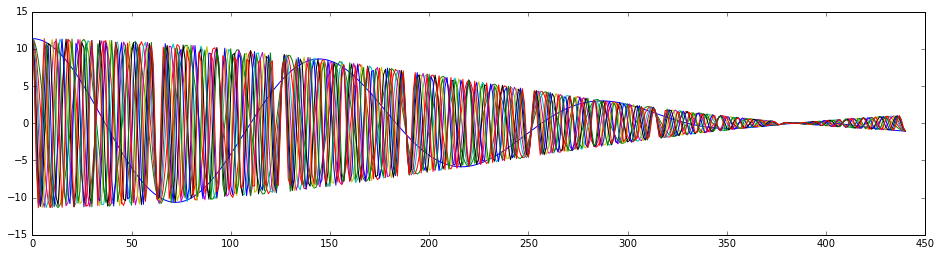

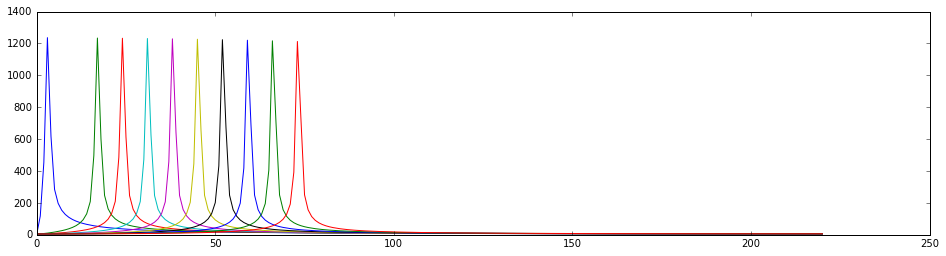

In [102]:
for i in pulses:
    plt.plot(pulses[i])
plt.show()

for i in pulses:
    plt.plot(np.abs(np.fft.rfft(pulses[i])))

In [104]:
for j in range(0, len(pulses)):
    pulse_cct = pulses[j]
    for i in range(0, 100):
        pulse_cct = np.concatenate((pulse_cct, pulses[j]))
    #plt.plot(np.abs(np.fft.fft(pulse_cct*10000 + channel[0:len(pulse_cct)])))
    #plt.show()

## Emitter

In [105]:
textfile = open('textfile.txt', 'r')
message = textfile.read()[:-1]
textfile.close()

In [106]:
message_bin = binarize(message)
assert message == textarize(message_bin)
len(message_bin)

1096

In [107]:
signal_delim = pulses[0]
Audio(signal_delim, rate=rate)

In [108]:
signal_window = pulses[1]
Audio(signal_window, rate=rate)

In [109]:
signal_window = pulses[2]
Audio(signal_window, rate=rate)

In [110]:
signal_window = pulses[4]
Audio(signal_window, rate=rate)

In [127]:
signal_data = []

for c in [message_bin[n:n + pulse_bits] for n in range(0, len(message_bin), pulse_bits)]:
    for redundentSymbol in range(0, redundency):   
        p = np.zeros(len(pulses[0]))
        for b in np.arange(0, len(c)):
            p += pulses[b + 1 + pulse_bits * c[b]]

        signal_data.extend(p)

In [128]:
signal_delay = np.zeros(origin_dt * rate)
signal = np.concatenate((signal_delay, signal_delim, signal_delim, signal_data, signal_delim, signal_delay))
Audio(signal, rate=rate)

In [129]:
time = len(signal) / rate - 2 * origin_dt
time

13.73

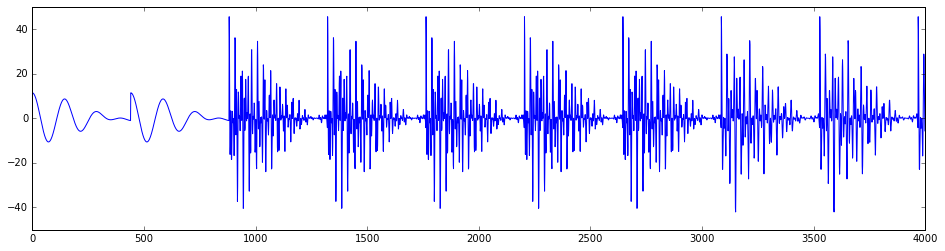

In [130]:
plt.plot(signal[origin_dt * rate :origin_dt* rate + 4000])

In [131]:
recorded = signal 

## Receiver

In [ ]:
recorded = record(time + origin_dt * 3, rate)
Audio(recorded, rate=rate)

In [118]:
xcorr = fast_corr(recorded, signal_delim)

In [119]:
mid = len(xcorr) // 2
corr_end = len(xcorr) - np.argmax(xcorr[mid:][::-1])
corr_start = np.argmax(xcorr[:mid])
[corr_start, corr_end]


[44100, 649153]

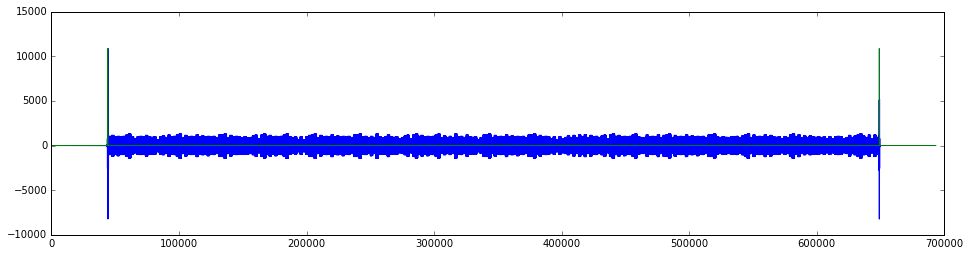

In [120]:
plt.plot(xcorr)
corr_bounds = np.zeros(len(xcorr))
corr_bounds[corr_start] = np.max(xcorr)
corr_bounds[corr_end] = np.max(xcorr)
plt.plot(corr_bounds)

In [121]:
isolated = recorded[corr_start + int(pulse_dt * rate):corr_end]

In [122]:
decoded = []

matched = [fast_corr(isolated, pulses[i + 1]) for i in np.arange(0, pulse_bits, 1)]
matched2 = [fast_corr(isolated, pulses[i + 1]) for i in np.arange(pulse_bits, pulse_bits*2, 1)]

sampled = np.abs([m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matched])
sampled2 = np.abs([m[np.arange(0, len(m), int(pulse_dt * rate))] for m in matched2]) 

    
for c in np.arange(0, len(sampled[0])):
    for b in np.arange(0, pulse_bits):
        tmp = 1 if sampled[b][c] < sampled2[b][c] else 0
        decoded.append(tmp)

In [123]:
remove_redundency = []

for symbolIndex in range(0, (len(decoded) // (redundency* pulse_bits))):
    tmp = []
    
    for l in range (0, pulse_bits):
        current = []
        for j in range (0, redundency):
            current.append(decoded[symbolIndex*pulse_bits*redundency + j*pulse_bits + l])
        tmp.append(current)
        
    for l in range (0, len(tmp)):
        median = np.median(tmp[l])
        assert int(median) == median
        tmp[l] = int(median)
        
    remove_redundency.append(tmp)

out = []
for symbol in remove_redundency:
    for bit in symbol:
        out.append(bit)

for i in range(0,8):
    print(str(i) + ':  ' + textarize(out[i:]))
          
len(out)

0:  The mediocre teacher tells. The good teacher explains. The superior teacher demonstrates. The great teacher gives reading assignments :-)
1:  ¨ÐÊ@ÚÊÈÒÞÆäÊ@èÊÂÆÐÊä@èÊØØæ\@¨ÐÊ@ÎÞÞÈ@èÊÂÆÐÊä@ÊðàØÂÒÜæ\@¨ÐÊ@æêàÊäÒÞä@èÊÂÆÐÊä@ÈÊÚÞÜæèäÂèÊæ\@¨ÐÊ@ÎäÊÂè@èÊÂÆÐÊä@ÎÒìÊæ@äÊÂÈÒÜÎ@ÂææÒÎÜÚÊÜèæ@tZ)
2:  Q¡µ¥½ÉÑ¡ÈÑ±±Ì¸Q¡½½Ñ¡ÈáÁ±¥¹Ì¸Q¡ÍÕÁÉ¥½ÈÑ¡Èµ½¹ÍÑÉÑÌ¸Q¡ÉÐÑ¡È¥ÙÌÉ¥¹ÍÍ¥¹µ¹ÑÌè´)
3:  £C)k+#K{)£+C+£+ccq£C);{{!£+C++ÃcKsq£C)«+K{£+C+#+k{s££+q£C);+¡£+C+;K³++#Ks9K;sk+s£Ñi	
4:  FRÖVFö7&RFV6W"FVÆÇ2âFRvööBFV6W"WÆç2âFR7WW&÷"FV6W"FVÖöç7G&FW2âFRw&VBFV6W"vfW2&VFær76væÖVçG2¢Ò	
¬¬-ìnL¤¬,m®D­eÄ
--ÎeÄ
¤n®®M-îD¬,m®D­­íÎnL.®eÄ
¤îL¬.¬,m®Dí.Ì®dL¬,-Ìä.nm,íÍ¬­ÎdE¥
6:  HYY[ØÜHXXÚ\[ËHÛÛÙXXÚ\^Z[ËHÝ\\[ÜXXÚ\[[ÛÝ]\ËHÜX]XXÚ\Ú]\ÈXY[È\ÜÚYÛY[ÈJ
7:  426²²4·±¹2:2°±´2¹:2¶69*42

1096

In [124]:
def lcs(t1, t2):
    s1 = "".join([str(c) for c in t1])
    s2 = "".join([str(c) for c in t2])
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

In [125]:
len(lcs(out, message_bin))

1096